
<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/NCAR-contemp-logo-blue.png"
     width="750px"
     alt="NCAR logo"
     style="vertical-align:middle;margin:30px 0px"/>

# Introduction to Xarray
**ESDS 2024 Annual Event Xarray-Dask Tutorial | January 19th, 2023**  

Negin Sobhani and Brian Vanderwende
Computational & Information Systems Lab (CISL)  
[negins@ucar.edu](mailto:negins@ucar.edu), [vanderwb@ucar.edu](mailto:vanderwb@ucar.edu)

------

### In this tutorial, you learn:

* Xarray Overview
* Understand the basic data structures in Xarray
* Inspect `DataArray` and `Dataset` objects.
* Read and write netCDF files using Xarray.
* Understand that there are many packages that build on top of xarray


### Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| Basic familiarity with NumPy	 | Necessary | |
| Basic familiarity with Pandas	 | Necessary | |

- **Time to learn**: 40 minutes

---------

<img src="https://docs.xarray.dev/en/stable/_static/Xarray_Logo_RGB_Final.svg"
     width="50%"
     alt="Xarray"
     style="vertical-align:middle;margin:30px 0px"/>

## Introduction

### What is Xarray?
     
Xarray is an open-source Python library designed for working with *labelled multi-dimensional* data. 

By *multi-dimensional* data (also often called *N-dimensional*), we mean data that has many independent dimensions or axes (e.g. latitude, longitude, time).

By *labelled* we mean that these axes or dimensions are associated with coordinate names (like "latitude") and coordinate labels like "30 degrees North".

<img src="https://docs.xarray.dev/en/stable/_images/dataset-diagram.png"
     width="50%"
     alt="Xarray"
     style="vertical-align:middle;margin:30px 0px"/>

*Image credit: Xarray Contributors*

The diagram above shows an example of a labelled multi-dimensional data with two variables (`temperature` and `precipitation`) and three coordinate vectors (e.g., `latitude`, `longitude`, `time`) that describe the data.
     
### Xarray Fundamental Data Structures

Xarray has two fundamental data structures:

* `DataArray` : holds a single multi-dimensional variable and its coordinates
* `Dataset` : holds multiple DataArrays that potentially share the same coordinates


#### Xarray DataArray

**Xarray DataArray = data + (a lot of) metadata**

A `DataArray` has four attributes:
* **Underlying Data** or `data`: a Numpy or Numpy-like array holding the values.
* **Named Dimensions** or `dims`: dimension names for each axis (e.g., `latitude`, `longitude`, `time`).
* **Coordinate Variables** or `coords`: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings).
* **Arbitrary attributes** or `attrs`: a dictionary to hold arbitrary metadata (attributes).

#### Xarray DataSet

**Xarray Dataset = multiple DataArrays**

A dataset is simply an object containing multiple Xarray DataArrays indexed by variable name that potentially share the same coordinates.

Let's open a tutorial dataset and see what these data structures look like. Here we'll use `air temperature` from the [National Center for Environmental Prediction](https://www.weather.gov/ncep/). Xarray objects have convenient HTML representations to give an overview of what we're working with:

In [47]:
import xarray as xr
xr.set_options(display_expand_attrs=False, display_expand_data=False);

In [48]:
ds = xr.tutorial.load_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes: (5)

Checkout the variables and coordinates of the dataset. You can also create a data Array from the dataset:

In [52]:
da = ds['air']
da

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
241.2 242.5 243.5 244.0 244.1 243.9 ... 297.9 297.4 297.2 296.5 296.2 295.7
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes: (11)

What are the dimensions of this data array?

In [45]:
da.dims

('time', 'lat', 'lon')

## Xarray Indexing and Selecting Data

Xarray supports different ways to index and select data. Xarray indexing is what makes it so powerful for analysis tasks. 

In total, xarray supports four different kinds of indexing, as described below and summarized in this table:

| Dimension lookup | Index lookup | `DataArray` syntax   |   `Dataset` syntax   |
| ---------------- | ------------ | ---------------------| ---------------------|
| Positional       | By integer   | `da[:,0]`            | *not available*      |
| Positional       | By label     | `da.loc[:,'IA']`     | *not available*      |
| By name          | By integer   | `da.isel(space=0)` or `da[dict(space=0)]`  | `ds.isel(space=0)` or  `ds[dict(space=0)]`  |
| By name          | By label     | `da.sel(space='IA')` or `da.loc[dict(space='IA')]` | `ds.sel(space='IA')` or `ds.loc[dict(space='IA')]` |


----------



### Positional indexing 
Position based indexing requires that we know the integer position of the data point we want. For example, if we want to select the first element of the `lat` dimension, we can use the following syntax (0-based indexing similar to NumPy).

In [88]:
da[1, 0, 0]

<xarray.DataArray 'air' ()>
242.1
Coordinates:
    lat      float32 75.0
    lon      float32 200.0
    time     datetime64[ns] 2013-01-01T06:00:00
Attributes: (11)

But which dimension is the `lat` dimension? My brain is not big enough to remember the order of dimensions in all the datasets I work with. Is there a better way?

Yes! You can use dimension names instead of integers to select data.

### Positional Indexing Using Dimension Names (`.isel`)
Remembering the axis order can be challenging even with multidimensional arrays. Xarray provides a more robust way to index data using dimension names instead of integers.

Xarray objects eliminate much of the mental overhead by allowing indexing using dimension names and instead of axes numbers and `isel`:

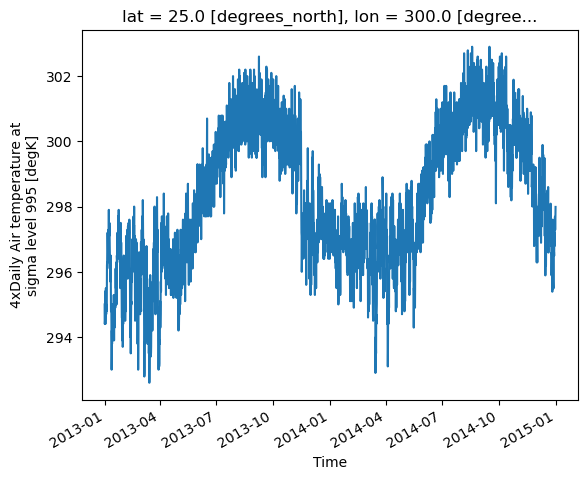

In [54]:
da.isel(lat=20, lon=40).plot();

Slicing with labels is also possible. For example, we can plot the first 20 time steps of the variable:

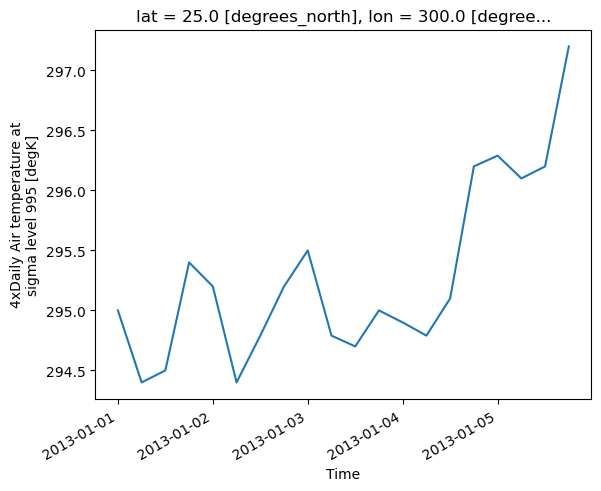

In [55]:
da.isel(time=slice(0, 20), lat=20, lon=40).plot();

Still this requires you to know which index corresponds to your desired label. What if you don’t know the index of the label you want? For example, what if you want to select the data for Lat 25 °N and Lon 210 °E N , but you don’t know which index corresponds to this point. 

### Label-based Indexing Using Dimension Names

Xarray provides a more robust way to index data using dimension names and labels (instead of indices) using `.sel` method. For example, let's select all data for Lat 25 °N and Lon 210 °E using `sel` :

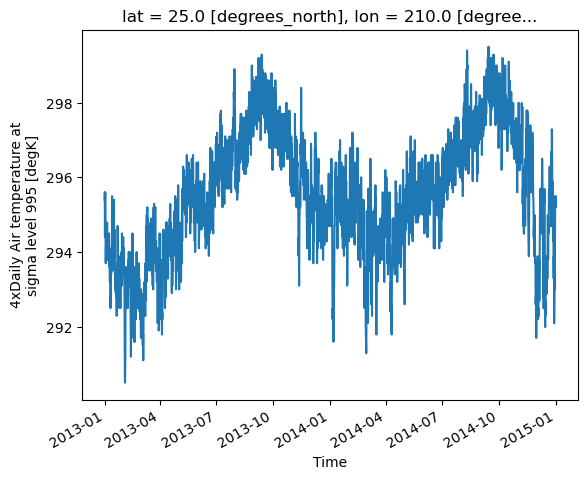

In [56]:
da.sel(lat=25, lon=210).plot();

We can also do slicing using labels. For example: 

In [57]:
da.sel(lat=slice(50, 25), lon=slice(210, 215));

This is a very powerful feature of Xarray. It allows you to select data without having to remember the order of dimensions or the indices of labels. 💪 🎉

## Reading and Writing Data with Xarray

One of Xarray's most widely used features is its ability to [read from and write
to a variety of data formats](https://docs.xarray.dev/en/stable/user-guide/io.html). 
For example, Xarray can read the following formats using `open_dataset`/`open_mfdataset`:

- [NetCDF](https://www.unidata.ucar.edu/software/netcdf/)
- [Zarr](https://zarr.readthedocs.io/en/stable/)
- [HDF5](https://www.hdfgroup.org/solutions/hdf5/)

Support for additional formats is possible using external packages
- [GRIB](https://en.wikipedia.org/wiki/GRIB) using the [cfgrib](https://github.com/ecmwf/cfgrib) package
- [GeoTIFF](https://gdal.org/drivers/raster/gtiff.html) /
  [GDAL rasters](https://svn.osgeo.org/gdal/tags/gdal_1_2_5/frmts/formats_list.html)
  using the [rioxarray package](https://corteva.github.io/rioxarray/stable/)

<img src="https://www.unidata.ucar.edu/images/logos/netcdf-400x400.png" align="right" width="20%">

## NetCDF
Xarray is built upon the netCDF data model, which means that netCDF files stored on disk directly represent Dataset objects. 


Xarray reads and writes to NetCDF files using the `open_dataset` /
`open_dataarray` functions and the `to_netcdf` method, respectively.

### Reading NetCDF file(s) with Xarray

Xarray provides a function called `open_dataset` that allows us to load a netCDF dataset into a Python data structure. To read more about this function, please see [xarray `open_dataset` API documentation](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html). 

Xarray also provides `open_mfdataset`, which open multiple files as a single xarray dataset. Passing the argument `parallel=True` will speed up reading multiple datasets by executing these tasks in parallel using Dask Delayed under the hood. We will learn more about Dask in the next section.

In this example, we are going to open one file from CESM2 Large Ensemble Data Sets (LENS). 
We will use 2m temperature (TREFHT) for this analysis. 

To learn more about LENS2 dataset, please visit:
* [LENS official website](https://www.cesm.ucar.edu/community-projects/lens/data-sets)
* [LENS paper](https://www.cesm.ucar.edu/community-projects/lens/data-sets)

For this tutorial, we only look at a small subset of data. If you don't have the data, running the following code enables you to download, prepare, and stage the required datasets (`../data/` folder) for this notebook.

LENS2 filenames follow the following naming convention:

`b.e21.XXXX.f09_g17.LE2-NNNNN.??????-??????.nc`

where `XXXX` is the scenarios, `NNNNN` is the ensemble member number and `??????-??????` is the time range of the data.

This [page](https://www.cesm.ucar.edu/models/cesm2/naming-conventions#:~:text=The%20naming%20conventions%20for%20CESM,%22post%2Dprocessed%20data%22.) provides more information about CESM2 output file naming conventions.

In [ ]:
import os
import glob

# set variable name
var = 'TREFHT' # near-surface air temperature
dates = '201501-202412'
data_dir = os.path.join('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/', var)
this_file = os.path.join(data_dir, 'b.e21.BSSP370smbb.f09_g17.LE2-1301.013.cam.h0.'+var+'.'+time+'.nc')

print (this_file)

In [ ]:
import xarray as xr

ds = xr.open_dataset(this_file)

In [33]:
ds.air

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
array([[[241.2    , 242.5    , 243.5    , ..., 232.79999, 235.5    ,
         238.59999],
        [243.79999, 244.5    , 244.7    , ..., 232.79999, 235.29999,
         239.29999],
        [250.     , 249.79999, 248.89   , ..., 233.2    , 236.39   ,
         241.7    ],
        ...,
        [296.6    , 296.19998, 296.4    , ..., 295.4    , 295.1    ,
         294.69998],
        [295.9    , 296.19998, 296.79   , ..., 295.9    , 295.9    ,
         295.19998],
        [296.29   , 296.79   , 297.1    , ..., 296.9    , 296.79   ,
         296.6    ]],

       [[242.09999, 242.7    , 243.09999, ..., 232.     , 233.59999,
         235.79999],
        [243.59999, 244.09999, 244.2    , ..., 231.     , 232.5    ,
         235.7    ],
        [253.2    , 252.89   , 252.09999, ..., 230.79999, 233.39   ,
         238.5    ],
...
        [293.69   , 293.88998, 295.38998, ..., 295.09   , 294.69   ,
         294.29   ],
        [296.29   , 297.19   , 297.59   , ..., 295.29   , 295.09   ,
         294.38998],
        [297.79   , 298.38998, 298.49   , ..., 295.69   , 295.49   ,
         295.19   ]],

       [[245.09   , 244.29   , 243.29   , ..., 241.68999, 241.48999,
         241.79   ],
        [249.89   , 249.29   , 248.39   , ..., 239.59   , 240.29   ,
         241.68999],
        [262.99   , 262.19   , 261.38998, ..., 239.89   , 242.59   ,
         246.29   ],
        ...,
        [293.79   , 293.69   , 295.09   , ..., 295.29   , 295.09   ,
         294.69   ],
        [296.09   , 296.88998, 297.19   , ..., 295.69   , 295.69   ,
         295.19   ],
        [297.69   , 298.09   , 298.09   , ..., 296.49   , 296.19   ,
         295.69   ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

## Basic Computations with Xarray

Xarray data arrays and datasets are compatible with arithmetic operators and numpy array functions, making it easy to work with arithmetic operators. 

For example, we can use the arithmetic operators `+`, `-`, `*`, `/`, `**` to add, subtract, multiply, divide, and exponentiate two xarray objects with the same dimensions. For example, we can convert the values from Kelvin to Celsius by subtracting 273.15 from the temperature values:

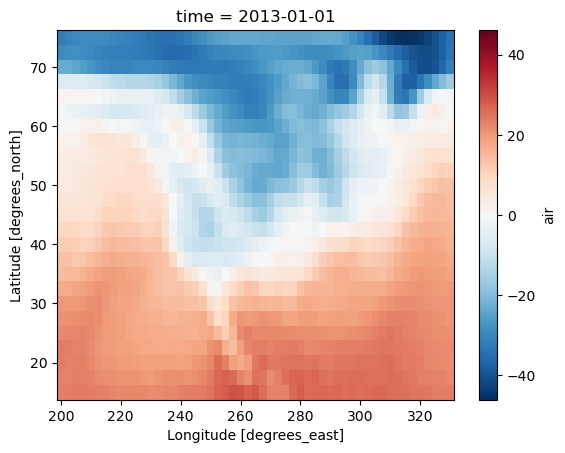

In [58]:
(da[0,:,]-273.15).plot();

### Reduction Operations

We can use similar statistical functions to compute the mean, standard deviation, variance, min, max, etc. of an xarray object. For example, we can compute the mean of the temperature values:

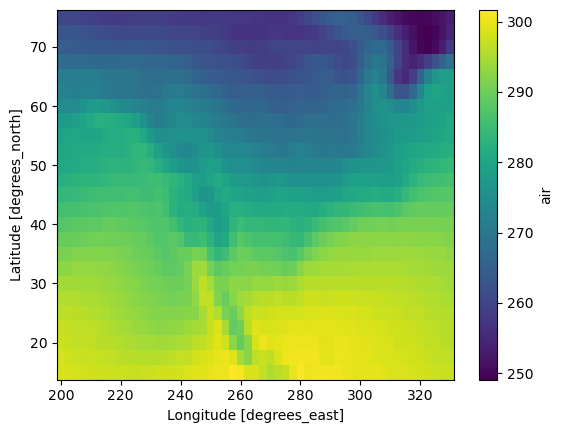

In [59]:
mean_temp = da.mean(dim="time")
mean_temp.plot();

In this example, we calculate the minimum temperature of each point for the time period:

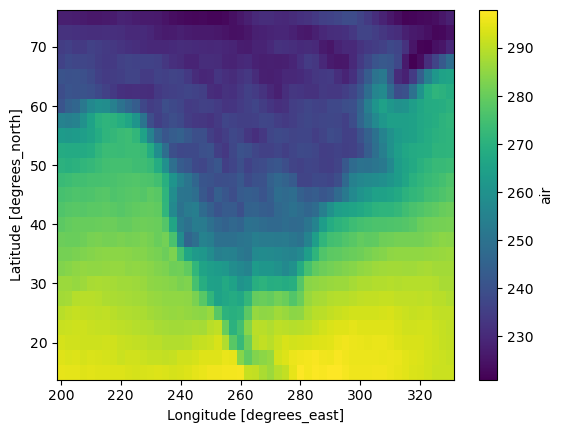

In [60]:
min_temp = da.min(dim=["time"])
min_temp.plot();

## Computing with Multiple Objects

### Alignment 

Alignment in xarray refers to the process of automatically aligning multiple DataArrays or Datasets based on their coordinates. Alignment ensures that the data along these coordinates is properly aligned before performing operations or calculations. This alignment is crucial because it enables xarray to handle operations on arrays with different sizes, shapes, and dimensions.



<img src="https://tutorial.xarray.dev/_images/alignment_schematic.png" width="1000">

### Broadcasting: adjusting arrays to the same shape

Broadcasting in Xarray refers to the automatic alignment and expansion of arrays to perform operations on arrays with different shapes and dimensions. It is a powerful feature that allows for efficient and convenient computations in Xarray. Broadcasting basically allows an operator or a function to act on two or more arrays to operate even if these arrays do not have the same shape. Xarray does broadcasting by dimension name, rather than array shape.

<img src="https://tutorial.xarray.dev/_images/broadcasting_schematic.png" width="1000">

Xarray broadcasting work similarly with CuPy and it preserves the data type. Here's an example to illustrate this:

Broadcasting in xarray simplifies the process of working with arrays of different shapes, as it automatically handles the alignment and expansion required for performing computations. It reduces the need for manual reshaping or padding of arrays, making the code more concise and readable. When doing certain computations on two arrays (additions), Xarray automatically broadcast the arrays to match the dimension shapes.  To learn more about `xarray.align` , you can check [the user guide](https://docs.xarray.dev/en/stable/generated/xarray.broadcast.html).

```{note}
If you encounter additional NaN values or missing data points after performing computations in xarray, it indicates that the coordinates of your xarray were not precisely aligned.
```

In [ ]:
---

## High level computation 

(`groupby`, `resample`, `rolling`, `coarsen`, `weighted`)

Xarray has some very useful high level objects that let you do common
computations:

1. `groupby` :
   [Bin data in to groups and reduce](https://docs.xarray.dev/en/stable/groupby.html)
1. `resample` :
   [Groupby specialized for time axes. Either downsample or upsample your data.](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)
1. `rolling` :
   [Operate on rolling windows of your data e.g. running mean](https://docs.xarray.dev/en/stable/user-guide/computation.html#rolling-window-operations)
1. `coarsen` :
   [Downsample your data](https://docs.xarray.dev/en/stable/user-guide/computation.html#coarsen-large-arrays)
1. `weighted` :
   [Weight your data before reducing](https://docs.xarray.dev/en/stable/user-guide/computation.html#weighted-array-reductions)


Below we quickly demonstrate these patterns. See the user guide links above and [the tutorial](https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html) for more.

### groupby

`groupby` is a powerful method that allows you to group DataArrays and Datasets by one or more dimensions. It is similar to the `groupby` method in Pandas.


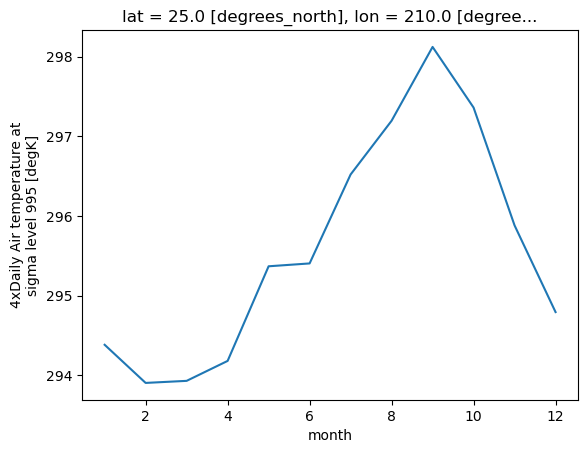

In [64]:
monthly_mean = da.groupby("time.month").mean()
monthly_mean.sel(lat=25, lon=210).plot();

In [67]:
# make a seasonal mean
seasonal_mean = ds.groupby("time.season").mean()
seasonal_mean

<xarray.Dataset>
Dimensions:  (lat: 25, season: 4, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    air      (season, lat, lon) float32 247.0 247.0 246.7 ... 299.4 299.4 299.5
Attributes: (5)

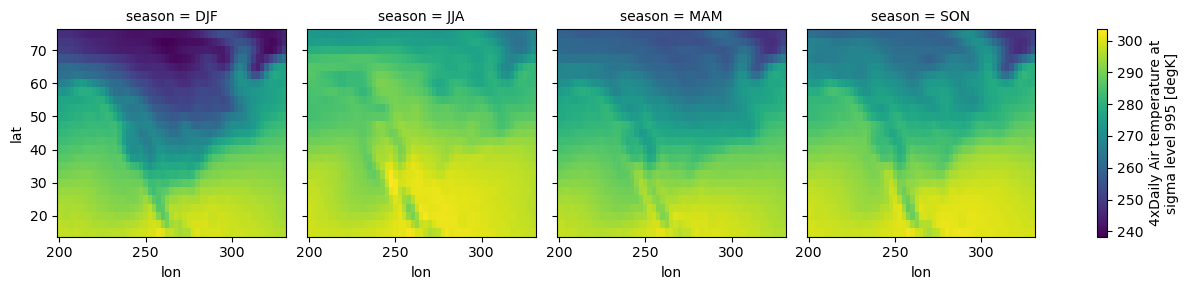

In [68]:
seasonal_mean.air.plot(col="season")

The seasons are out of order (they are alphabetically sorted). This is a common
annoyance. The solution is to use `.sel` to change the order of labels.


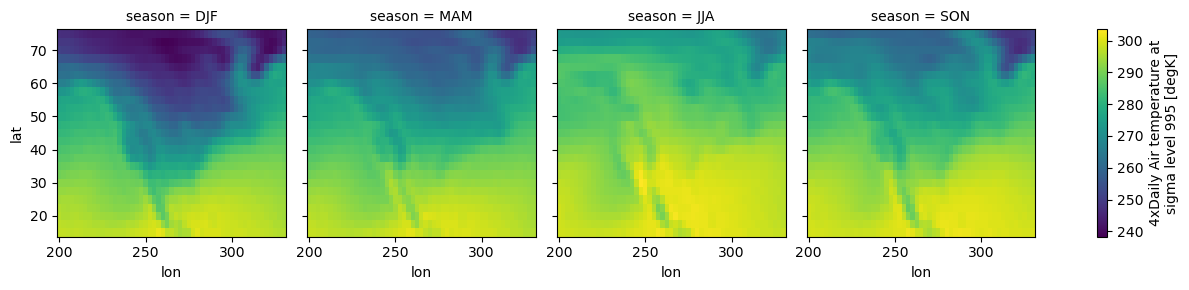

In [70]:
seasonal_mean = seasonal_mean.sel(season=["DJF", "MAM", "JJA", "SON"])
seasonal_mean.air.plot(col="season")

## Resampling

Resampling is a method for frequency conversion and downsampling of time series. Xarray provides a method called `resample` that allows you to resample time series data.


In [71]:
# resample to monthly frequency
ds.resample(time="M").mean()

<xarray.Dataset>
Dimensions:  (lat: 25, time: 24, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-31 2013-02-28 ... 2014-12-31
Data variables:
    air      (time, lat, lon) float32 244.5 244.7 244.7 ... 297.7 297.7 297.7
Attributes: (5)

## Weighted

Weighted array reductions in Xarray empower users with the ability to perform aggregations on multidimensional arrays while considering the weights assigned to each element. They currently support weighted sum, mean, std, var and quantile. By default, aggregation results in Xarray’s rolling window operations are assigned the coordinate at the end of each window. However, it is possible to center the results by specifying center=True when creating the Rolling object.

For example, the weighted mean is another way to smooth data, taking into account the varying importance of each data point.

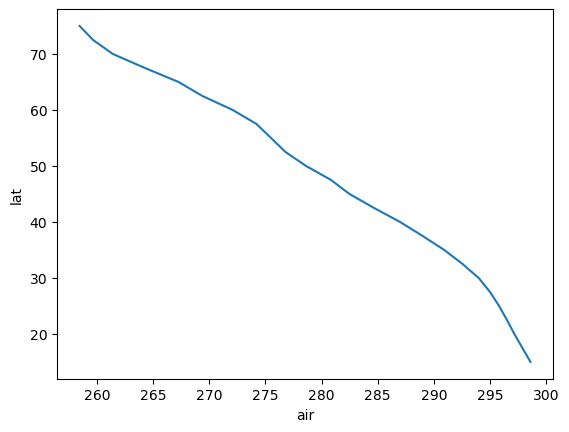

In [74]:
weights = xr.DataArray(da, dims=["time", "lat", "lon"])

ds.weighted(weights).mean(["lon", "time"]).air.plot(y="lat");

### Rolling

Xarray provides a method called `rolling` that allows you to perform rolling window operations on time series data. Rolling window operations are statistical operations that are applied to a window of time series data. For example, you can calculate the rolling mean of a time series to smooth out short-term fluctuations and highlight long-term trends.

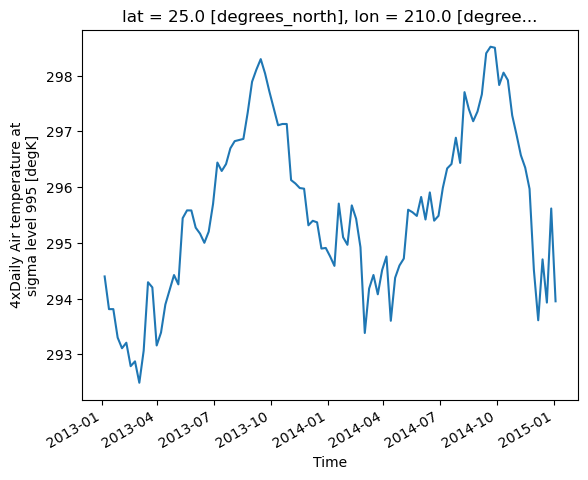

In [78]:
weekly_mean = da.resample(time="1W").mean()
weekly_mean.sel(lat=25, lon=210).plot();

### Coarsen

In Xarray, the coarsen operation is a powerful tool for downsampling or reducing the size of large arrays. When dealing with large datasets, coarsening allows for efficient summarization of data by aggregating multiple values into a single value within a defined coarsening window. This process is particularly useful when working with high-resolution or fine-grained data, as it enables the transformation of large arrays into smaller ones while preserving the overall structure and key characteristics of the data. 

In order to take a block mean for every 3 days along time dimension and every 2 points along lat and lon, we can use the following:

In [83]:
da

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
241.2 242.5 243.5 244.0 244.1 243.9 ... 297.9 297.4 297.2 296.5 296.2 295.7
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes: (11)

In [84]:
coarsen_da = da.coarsen(time=2,lat=5).mean()
coarsen_da

<xarray.DataArray 'air' (time: 1460, lat: 5, lon: 53)>
255.7 255.9 255.7 255.1 254.4 253.5 ... 296.0 295.7 295.3 295.0 294.8 294.5
Coordinates:
  * lat      (lat) float32 70.0 57.5 45.0 32.5 20.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01T03:00:00 ... 2014-12-31T15:00:00
Attributes: (11)

### Xarray can wrap many NumPy-like arrays


This notebook has focused on Numpy arrays. Xarray can wrap [other array](https://docs.xarray.dev/en/stable/user-guide/duckarrays.html) types! For example:

<img src="https://docs.dask.org/en/stable/_images/dask_horizontal.svg" width="20%"> [distributed parallel arrays](https://docs.dask.org/en/latest/array.html) & [Xarray user guide on Dask](https://docs.xarray.dev/en/stable/user-guide/dask.html)


<img src="https://raw.githubusercontent.com/pydata/sparse/master/docs/logo.svg" width="15%"> **pydata/sparse** : [sparse arrays](https://sparse.pydata.org)

<img src="https://raw.githubusercontent.com/cupy/cupy.dev/master/images/cupy_logo.png" width="22%"> [GPU arrays](https://cupy.dev) & [cupy-xarray](https://cupy-xarray.readthedocs.io/)

<img src="https://pint.readthedocs.io/en/stable/_static/logo-full.jpg" width="10%"> **pint** : [unit-aware arrays](https://pint.readthedocs.io) & [pint-xarray](https://github.com/xarray-contrib/pint-xarray)


For example, we will learn more about Xarray wrapping Dask arrays in the next section.

### Supplementary Material: Advanced using `apply_ufunc`

Sometimes, we want calculate a function that is not built-in to Xarray. For example, we may want to calculate the saturation vapor pressure.
`xr.apply_ufunc()` give users capability to run custom-written functions.  

Xarray, itself, use `apply_ufunc()` to implement many of its built-in functions. For example, this includes most of SciPy's API implementation in Xarray.

In the example below, we calculate the saturation vapor pressure by using `apply_ufunc()` to apply this function to our Dask Array chunk by chunk. 

In [85]:
import numpy as np

def sat_p(t):
    """Calculate saturation vapor pressure using Clausius-Clapeyron equation"""
    return 0.611 * np.exp(17.67 * (t-273.15)*((t-29.65)**(-1)))

In [86]:
es = xr.apply_ufunc(sat_p, da, output_dtypes=[float])
es

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
0.04237 0.04797 0.05273 0.05526 0.05578 0.0547 ... 3.026 2.989 2.866 2.814 2.73
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

The data used for this tutorial is from one ensemble member. What if we want to use multiple ensemble members? So far, we only run on one machine, what if we run an HPC cluster? We will go over this in the next tutorial.

## Summary

In this notebook, we have learned about:

* Xarray data structures: `DataArray` and `Dataset`
* Indexing and selecting data
* Reading and writing data with Xarray
* Basic computations with Xarray
* Broadcasting and alignment
* Customized workflows using `apply_ufunc`

## Resources and references

### Reference
* [Xarray Tutorial material](https://tutorial.xarray.dev/intro.html)
* [Project Pythia Foundations]()